# Práctica Final - AA

## Imports y funciones comunes

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from timeit import default_timer

from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.feature_selection import VarianceThreshold, SelectKBest, RFE, f_classif
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
from sklearn.linear_model import LinearRegression, LogisticRegression, SGDClassifier, RidgeClassifier, Perceptron
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.svm import SVC
from sklearn.dummy import DummyRegressor

#%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn.model_selection import learning_curve
from sklearn.metrics import plot_confusion_matrix as _plot_confusion_matrix

SEED = 23
MAX_ITER = 10000
np.random.seed(SEED)

do_pause = True  # True para pausar ejecución, False para ejecutar todo
pause = lambda: input("~~~ Pulse Intro para continuar ~~~") if do_pause else None

# ===========================================================================================================================
# FUNCIONES AUXILIARES
# ===========================================================================================================================

# ==== MANEJO DE DATOS ====

def df_from_data(filename, **kwargs):
    return pd.read_csv(filename, **kwargs)

def xy_from_df(df):
    X = df.values[:,:-1]
    y = df.values[:,-1]
    return X, y

def names_from_df(df):
    target = df.columns.values[-1]
    features = [f for f in df.columns if f != target]
    return features, target

def get_importances(X, y, features, model):
    model.fit(X, y)
    return list(zip(features, model.feature_importances_))

def get_importances_sorted(X, y, features, model):
    importances = get_importances(X, y, features, model)
    importances.sort(key=lambda x: x[1], reverse=True)
    return importances

def pca(df, target, n_components=2, standardizer=None, **pca_args):
    features = [f for f in df.columns if f != target]
    x = df.loc[:, features].values
    y = df.loc[:, [target]].values
    if standardizer: x = standardizer().fit_transform(x)
    
    tsne = PCA(n_components=n_components, **pca_args)
    tsne_results = tsne.fit_transform(x)
    tsne_df = pd.DataFrame(data=tsne_results, columns=[f'PCA{i+1}' for i in range(n_components)])
    final_df = pd.concat([tsne_df, df[[target]].astype(int)], axis=1)
    return final_df

def tsne(df, target, n_components=2, standardizer=None, **tsne_args):
    features = [f for f in df.columns if f != target]
    x = df.loc[:, features].values
    y = df.loc[:, [target]].values
    if standardizer: x = standardizer().fit_transform(x)
    
    tsne = TSNE(n_components=n_components, **tsne_args)
    tsne_results = tsne.fit_transform(x)
    tsne_df = pd.DataFrame(data=tsne_results, columns=[f'TSNE{i+1}' for i in range(n_components)])
    final_df = pd.concat([tsne_df, df[[target]].astype(int)], axis=1)
    return final_df

def get_metrics(model, metrics, X_train, y_train, X_test, y_test):
    output = {}
    for tag, X, y in [('train', X_train, y_train), ('test', X_test, y_test)]:
        y_pred = model.predict(X)
        model_metrics = {}
        for metric in metrics:
            model_metrics[metric.__name__] = metric(y, y_pred)
        output[tag] = model_metrics
    return output

def categories_plot(y_train, y_test):
    fig, ax = plt.subplots(1, 2, figsize=(10,4), dpi=200)
    ax[0].title.set_text("train")
    ax[1].title.set_text("test")
    values = []
    tags = list(set(y_train))
    for tag in tags:
        values.append(list(y_train).count(tag))
    ax[0].bar(tags, values)
    ax[0].set_xticks(tags)
    values = []
    tags = list(set(y_test))
    for tag in tags:
        values.append(list(y_test).count(tag))
    ax[1].bar(tags, values)
    ax[1].set_xticks(tags)
    return plt

# ==== GRÁFICAS ====

def plottable(function):
    def wrapper(*args, **kwargs):
        plt = function(*args)
        if 'xlabel' in kwargs.keys(): plt.xlabel(kwargs['xlabel'])
        if 'ylabel' in kwargs.keys(): plt.ylabel(kwargs['ylabel'])
        if 'title' in kwargs.keys(): plt.title(kwargs['title'])
        plt.show()
    return wrapper

@plottable
def plot_bar(tags, values):
    plt.figure(figsize=(20,6), dpi=200)
    plt.xticks(rotation=45)
    plt.bar(tags, values)
    return plt

@plottable
def plot_scatter_df(df, features, target):
    fig, ax = plt.subplots(1,2, figsize=(10,4), dpi=200)
    sns.scatterplot(x=features[0], y=target, data=df, ax=ax[0])
    sns.scatterplot(x=features[1], y=target, data=df, ax=ax[1])
    fig.tight_layout()
    return plt

@plottable
def plot_hist(data):
    plt.figure(dpi=200)
    plt.hist(data, edgecolor='white')
    return plt

@plottable
def plot_bar_data(data, labels=None):
    values = []
    tags = list(set(data))
    for tag in tags:
        values.append(list(data).count(tag))
    if labels: tags = [labels[tag] for tag in tags]
    plt.figure(dpi=200)
    plt.bar(tags, values)
    plt.xticks(tags)
    return plt

@plottable
def plot_correlations(X, X_pre):
    fig, ax = plt.subplots(1,2, figsize=(10, 4), dpi=200)
    # correlación antes de preprocesado
    with np.errstate(invalid='ignore'):  # ignorar inválidos sin procesar
        corr = np.abs(np.corrcoef(X.astype(float), rowvar=False))
    im = ax[0].matshow(corr, cmap='viridis')
    ax[0].title.set_text("Antes de preprocesado")
    # correlación tras preprocesado
    corr_pre = np.abs(np.corrcoef(X_pre.astype(float), rowvar=False))
    im = ax[1].matshow(corr_pre, cmap='viridis')
    ax[1].title.set_text("Tras preprocesado")
    fig.colorbar(im, ax=ax.ravel().tolist(), shrink=0.6)
    return plt

@plottable
def plot_learning_curve(estimator, X, y, scoring, title=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    # Basado en: https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html

    fig, axes = plt.subplots(1, 3, figsize=(20, 5), dpi=200)
    
    if scoring == 'accuracy':
        score_name = 'Accuracy'
    elif scoring == 'neg_mean_squared_error':
        # si es neg_mean_squared_error, representamos la raíz de MSE
        score_name = 'Raíz de MSE'
    else:
        score_name = scoring

    if title: axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel(score_name)

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    #if scoring == 'neg_mean_squared_error':
    #    train_scores = np.sqrt(-train_scores)
    #    test_scores = np.sqrt(-test_scores)
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")
    axes[0].set_title("Learning curve")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

@plottable
def plot_confusion_matrix(model, X_train, X_test, y_train, y_test):
    fig, ax = plt.subplots(1,2, figsize=(10, 4), dpi=200)
    img = _plot_confusion_matrix(model, X_train, y_train, cmap='viridis', values_format='d', ax=ax[0], colorbar=False)
    img.ax_.set_title("Matriz de confusión en train")
    img.ax_.set_xlabel("etiqueta predicha")
    img.ax_.set_ylabel("etiqueta real")
    img = _plot_confusion_matrix(model, X_test, y_test, cmap='viridis', values_format='d', ax=ax[1], colorbar=False)
    img.ax_.set_title("Matriz de confusión en test")
    img.ax_.set_xlabel("etiqueta predicha")
    img.ax_.set_ylabel("etiqueta real")
    return plt

## Código

### Cargar datos en DF

In [2]:
excel_data_df = pd.read_excel('./datos/CTG.xls', sheet_name='Data')

In [3]:
data = np.concatenate((excel_data_df.values[:-3,10:31], excel_data_df.values[:-3, 45].reshape(-1,1)), axis=1)

In [4]:
df = pd.DataFrame(data[1:,:], columns=data[0,:])

In [5]:
df

,LB,AC,FM,UC,DL,DS,DP,ASTV,MSTV,ALTV,...,Min,Max,Nmax,Nzeros,Mode,Mean,Median,Variance,Tendency,NSP
0,120,0,0,0,0,0,0,73,0.5,43,...,62,126,2,0,120,137,121,73,1,2
1,132,0.00638,0,0.00638,0.00319,0,0,17,2.1,0,...,68,198,6,1,141,136,140,12,0,1
2,133,0.003322,0,0.008306,0.003322,0,0,16,2.1,0,...,68,198,5,1,141,135,138,13,0,1
3,134,0.002561,0,0.007682,0.002561,0,0,16,2.4,0,...,53,170,11,0,137,134,137,13,1,1
4,132,0.006515,0,0.008143,0,0,0,16,2.4,0,...,53,170,9,0,137,136,138,11,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2121,140,0,0,0.007426,0,0,0,79,0.2,25,...,137,177,4,0,153,150,152,2,0,2
2122,140,0.000775,0,0.006971,0,0,0,78,0.4,22,...,103,169,6,0,152,148,151,3,1,2
2123,140,0.00098,0,0.006863,0,0,0,79,0.4,20,...,103,170,5,0,153,148,152,4,1,2
2124,140,0.000679,0,0.00611,0,0,0,78,0.4,27,...,103,169,6,0,152,147,151,4,1,2


### Explorar dataset

In [6]:
pd.DataFrame({'min': df.min(axis=0).values, 'max': df.max(axis=0).values, 'mean': df.mean(axis=0).values, 'std': df.std(axis=0).values}, index=df.columns.values)

,min,max,mean,std
LB,106,160,133.303857,9.840844
AC,0,0.019284,0.003170,0.003860
FM,0,0.480634,0.009474,0.046670
UC,0,0.014925,0.004357,0.002940
DL,0,0.015385,0.001885,0.002962
DS,0,0.001353,0.000004,0.000063
DP,0,0.005348,0.000157,0.000580
ASTV,12,87,46.990122,17.192814
MSTV,0.2,7,1.332785,0.883241
ALTV,0,91,9.846660,18.396880


In [7]:
X, y = xy_from_df(df)
X = X.astype(float)
y = y.astype(int)

features, target = names_from_df(df)
X, y = xy_from_df(df)

features = [f for f in df.columns if f != target]

# dividimos en train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)
y_train = y_train.astype(int)
y_test = y_test.astype(int)

In [8]:
#df_train_scaled = pd.DataFrame(np.concatenate((StandardScaler().fit_transform(X_train), y_train.reshape(-1,1)), axis=1), columns=data[0,:])
#df_train_scaled.boxplot(figsize=(12,6), rot=90, column=data[0,:])

In [9]:
df_train = pd.DataFrame(np.concatenate((X_train, y_train.reshape(-1,1)), axis=1), columns=data[0,:])

In [10]:
df_tsne = tsne(df_train, 'NSP', n_components=2, standardizer=StandardScaler)
df_tsne

,TSNE1,TSNE2,NSP
0,0.292807,16.930683,1
1,27.027193,19.071659,1
2,23.759977,-10.985746,1
3,36.723095,5.480191,1
4,-8.223451,-39.466007,2
...,...,...,...
1695,21.189140,13.907253,1
1696,-23.456440,28.457758,1
1697,-23.213381,10.217530,1
1698,38.501713,-15.511458,2


Gráfica: Proyección t-SNE 2D


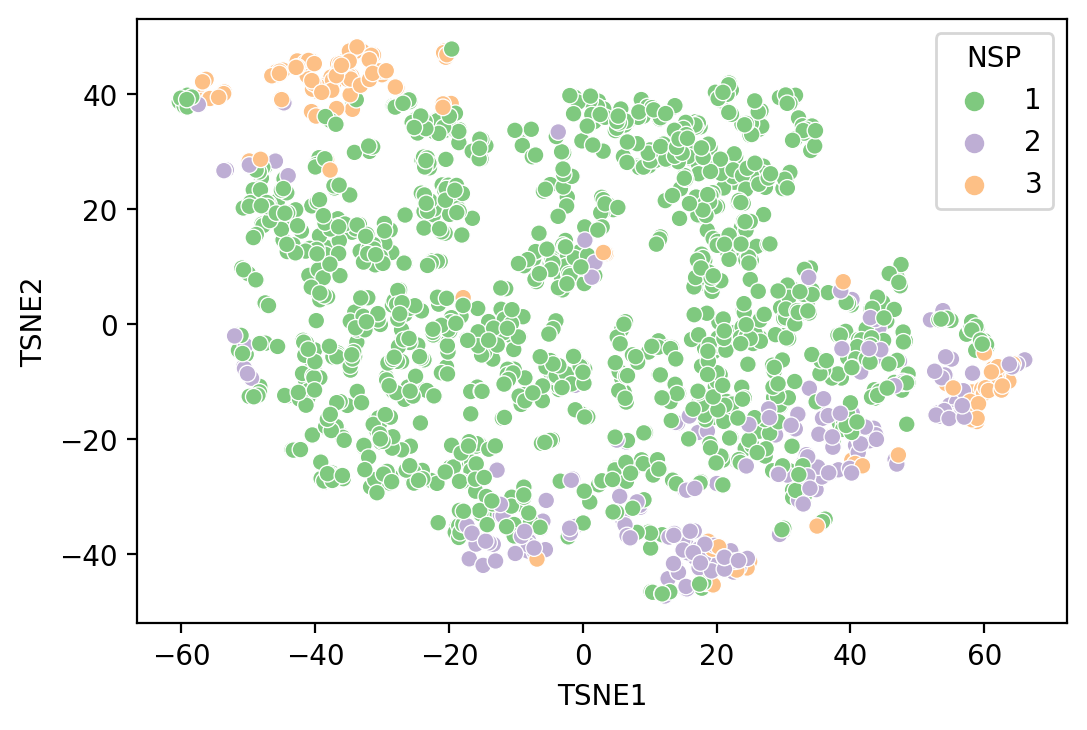

In [11]:
plt.subplots(dpi=200)
sns.scatterplot(x="TSNE1", y="TSNE2", data=df_tsne, hue='NSP', palette="Accent")
print("Gráfica: Proyección t-SNE 2D")

In [12]:
df_pca = pca(df_train, 'NSP', n_components=2, standardizer=StandardScaler)
df_pca

,PCA1,PCA2,NSP
0,1.365583,1.485481,1
1,-1.153416,1.408578,1
2,-2.211910,-0.280799,1
3,-1.528091,2.008156,1
4,-1.672566,0.481080,2
...,...,...,...
1695,-0.308234,0.667030,1
1696,2.064109,1.252843,1
1697,1.628013,0.359235,1
1698,-2.806075,0.813474,2


Gráfica: Proyección PCA 2D


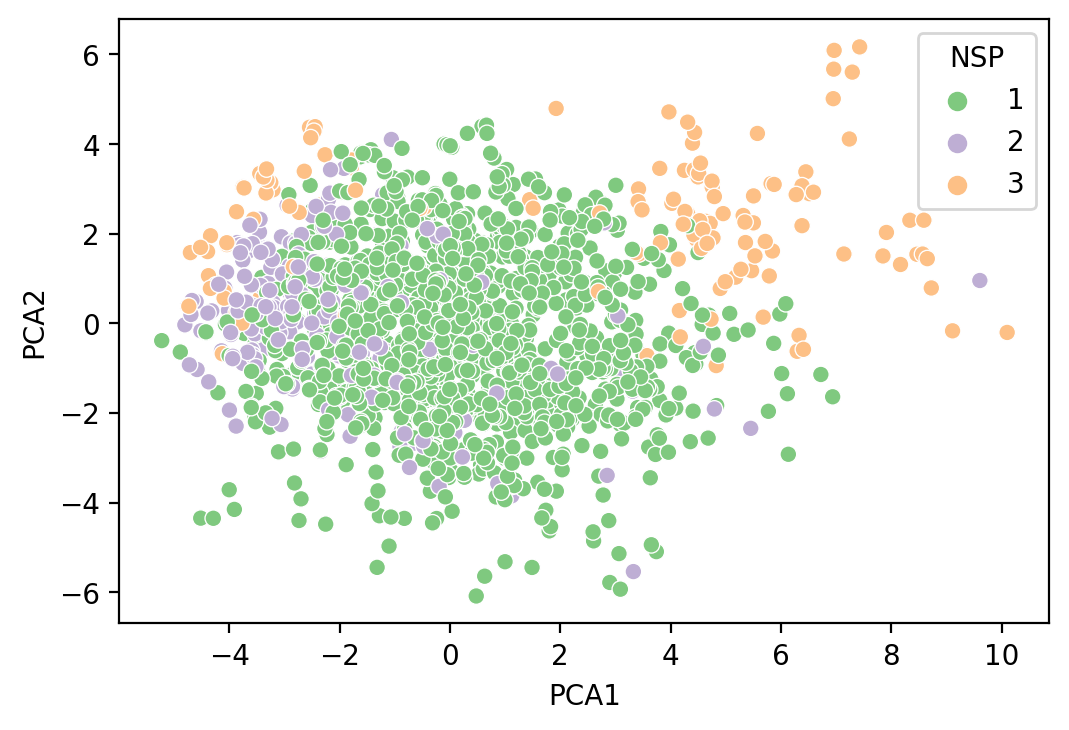

In [13]:
plt.subplots(dpi=200)
sns.scatterplot(x="PCA1", y="PCA2", data=df_pca, hue='NSP', palette="Accent")
print("Gráfica: Proyección PCA 2D")

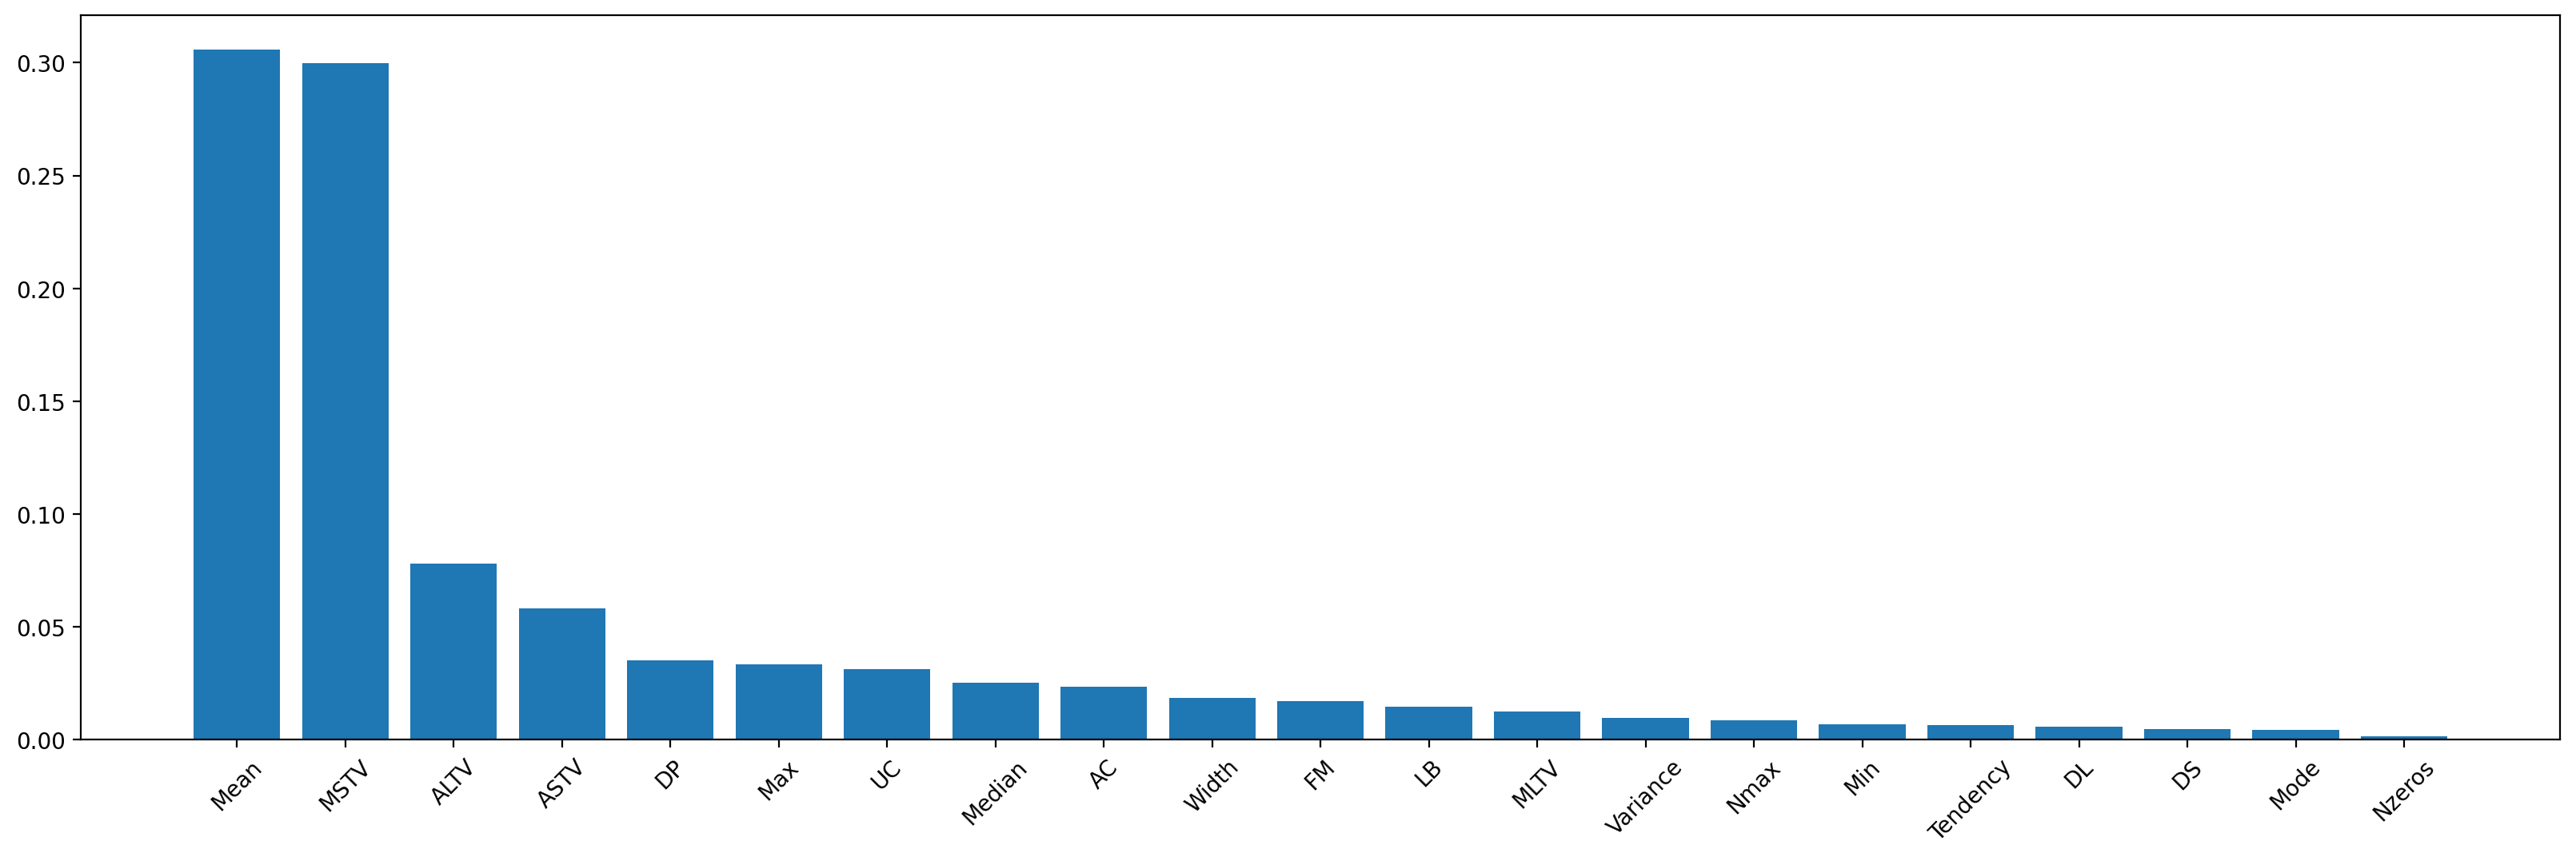

Gráfica: Importancia de variables segúnDecisionTreeRegressor


In [14]:
importances_sorted = get_importances_sorted(X, y, features, model=DecisionTreeRegressor())
plot_bar(list(list(zip(*importances_sorted)))[0], list(zip(*importances_sorted))[1])
print("Gráfica: Importancia de variables segúnDecisionTreeRegressor")

### Pipeline de preprocesado

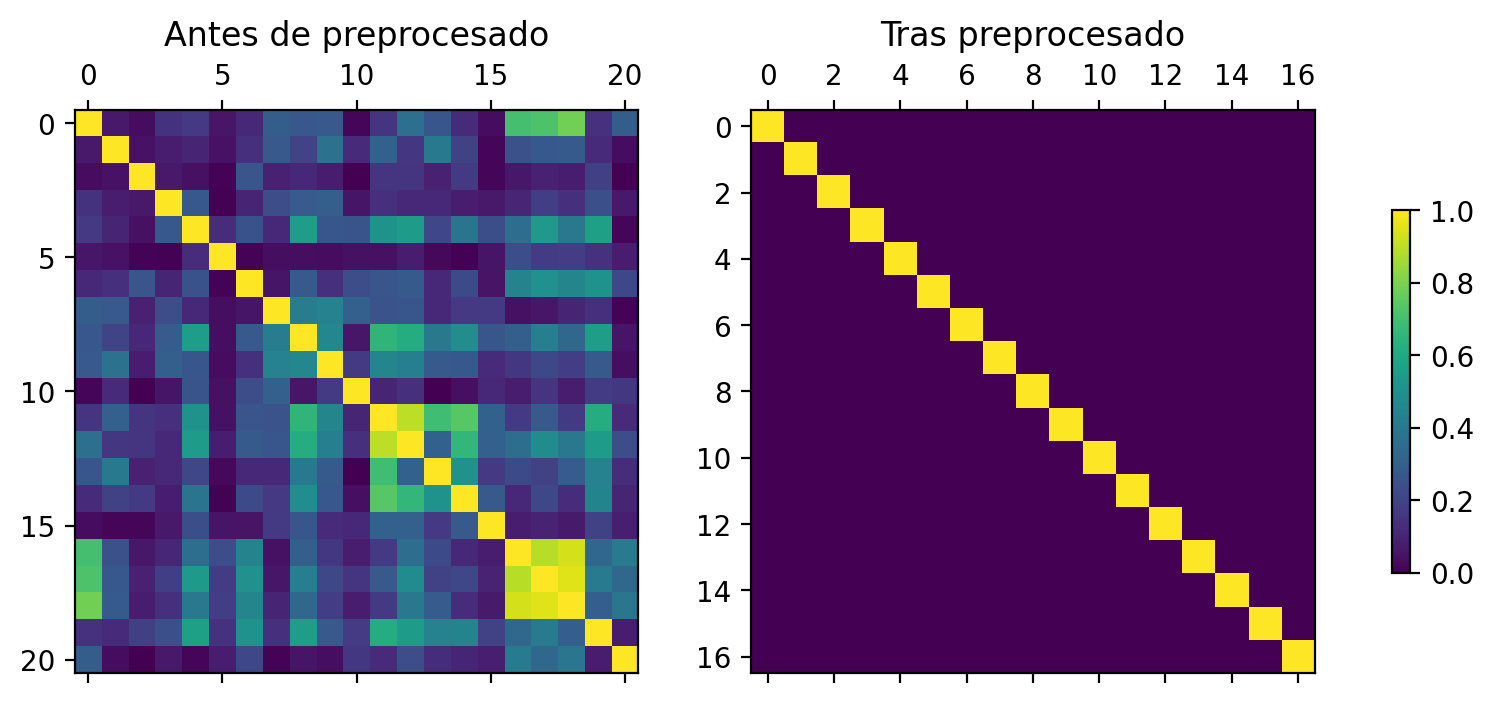


Gráfica: Matriz de correlación antes y después del preprocesado


In [15]:
# PREPROCESADO
preprocessing = [
    ("standardization", StandardScaler()),
    ("dimreduction", PCA(0.99)),
]

# REGRESIÓN

# hacemos pipeline de preprocesado
preprocessing_pipeline = Pipeline(preprocessing)

# obtenemos los datos preprocesados
X_train_pre = preprocessing_pipeline.fit_transform(X_train, y_train)
X_test_pre = preprocessing_pipeline.transform(X_test)

# creamos pipeline de entrenamiento
pipeline = Pipeline(preprocessing + [("clf", LinearRegression())])

plot_correlations(X_train, X_train_pre)
print("\nGráfica: Matriz de correlación antes y después del preprocesado")

In [16]:
X_train_pre.shape

(1700, 17)

### Categorías en train y en test

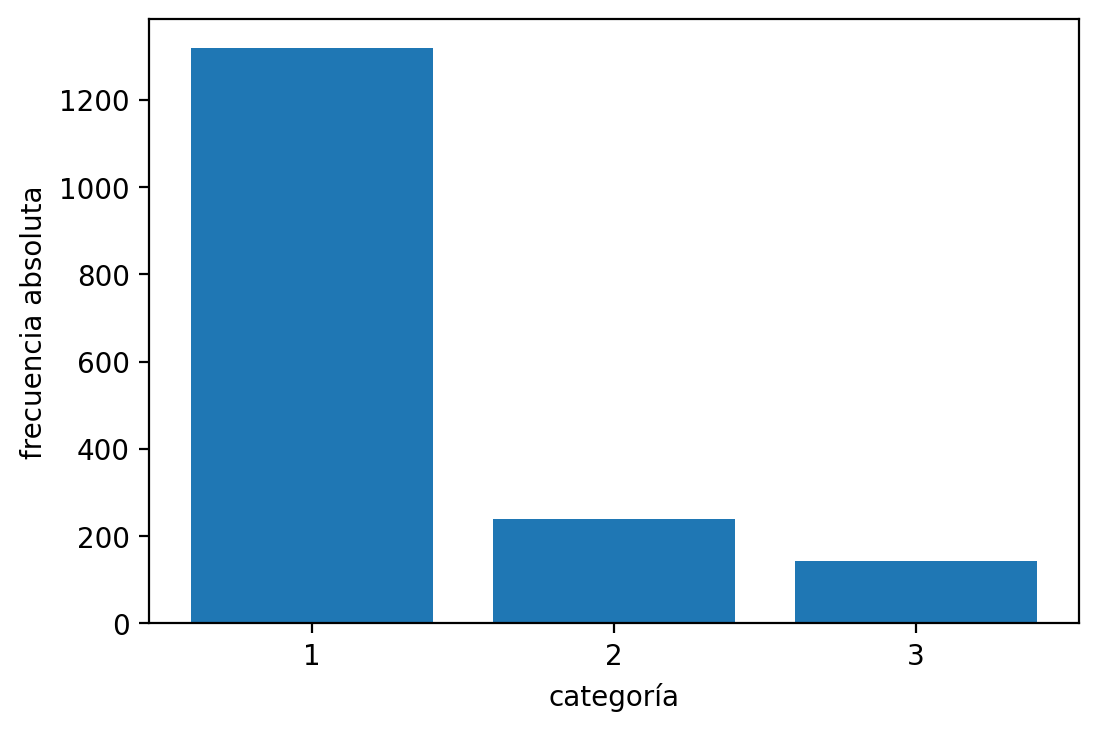

Gráfica: Frecuencia de target en train


In [17]:
plot_bar_data(y_train, xlabel="categoría", ylabel="frecuencia absoluta")
print("Gráfica: Frecuencia de target en train")

### Entrenamiento

In [18]:
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier

# especificamos los modelos (espacio de búsqueda)
search_spaces = {
    'logistic':
        {"clf": [SGDClassifier(loss='log', max_iter=MAX_ITER, random_state=SEED)],
         "clf__penalty": ['l1', 'l2'],
         "clf__alpha": np.logspace(-5, -1, 10)},
    'svm':
        {"clf": [SVC(kernel='rbf', max_iter=MAX_ITER)],
         "clf__gamma": ['auto', 'scale'],
         "clf__C": np.logspace(0, 4, 10)},
    'nn':
        {"clf": [MLPClassifier(learning_rate="adaptive", activation="tanh", solver="sgd", max_iter=2000)],
         "clf__hidden_layer_sizes": [40, 50, 60],
         "clf__alpha": np.logspace(-3, 1, 5)},
    'random_forest':
        {"clf": [RandomForestClassifier(random_state = SEED)],
         "clf__max_depth": [5, 10, 15, 20],
         "clf__n_estimators": [50, 100, 200, 400, 600]}
}

In [19]:
best_models = {key: GridSearchCV(pipeline, search_spaces[key], scoring='accuracy', cv=5, n_jobs=-1, verbose=10) for key in search_spaces.keys()}
time = {}

for key in best_models.keys():
    t0 = default_timer()
    best_models[key].fit(X_train, y_train)
    time[key] = default_timer() - t0

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 15 candidates, totalling 75 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits


In [20]:
best_params = {key: best_models[key].best_params_ for key in best_models.keys()}
best_estimators = {key: best_models[key].best_estimator_ for key in best_models.keys()}
best_scores = {key: best_models[key].best_score_ for key in best_models.keys()}

print("\nParámetros de los mejores modelos:")
print(best_params)
print("\nAccuracy en CV de los mejores modelos:")
print(best_scores)



Parámetros de los mejores modelos:
{'logistic': {'clf': SGDClassifier(alpha=0.0016681005372000592, loss='log', max_iter=10000,
              random_state=23), 'clf__alpha': 0.0016681005372000592, 'clf__penalty': 'l2'}, 'svm': {'clf': SVC(C=166.81005372000593, max_iter=10000), 'clf__C': 166.81005372000593, 'clf__gamma': 'scale'}, 'nn': {'clf': MLPClassifier(activation='tanh', alpha=0.001, hidden_layer_sizes=50,
              learning_rate='adaptive', max_iter=2000, solver='sgd'), 'clf__alpha': 0.001, 'clf__hidden_layer_sizes': 50}, 'random_forest': {'clf': RandomForestClassifier(max_depth=15, n_estimators=400, random_state=23), 'clf__max_depth': 15, 'clf__n_estimators': 400}}

Accuracy en CV de los mejores modelos:
{'logistic': 0.8994117647058824, 'svm': 0.9305882352941175, 'nn': 0.9017647058823529, 'random_forest': 0.908235294117647}


In [34]:
metrics = {key: get_metrics(best_models[key], [accuracy_score], X_train, y_train, X_test, y_test) for key in best_models.keys()}
metrics

{'logistic': {'train': {'accuracy_score': 0.9017647058823529},
  'test': {'accuracy_score': 0.8873239436619719}},
 'svm': {'train': {'accuracy_score': 0.9888235294117647},
  'test': {'accuracy_score': 0.9342723004694836}},
 'nn': {'train': {'accuracy_score': 0.9123529411764706},
  'test': {'accuracy_score': 0.8943661971830986}},
 'random_forest': {'train': {'accuracy_score': 0.9994117647058823},
  'test': {'accuracy_score': 0.9131455399061033}}}

In [44]:
measures = {}
for alg in search_spaces.keys():
    measures[alg] = {
        'cv'    : best_scores[alg],
        'train' : metrics[alg]['train']['accuracy_score'],
        'test'  : metrics[alg]['test']['accuracy_score'],
        'time'  : time[alg]
    }

measures

In [37]:
measures

{'cv': 0.908235294117647,
 'train': {'accuracy_score': 0.9994117647058823},
 'test': {'accuracy_score': 0.9131455399061033}}

In [45]:
pd.DataFrame(measures).transpose()

,cv,train,test,time
logistic,0.899412,0.901765,0.887324,3.888142
svm,0.930588,0.988824,0.934272,2.012794
nn,0.901765,0.912353,0.894366,60.074929
random_forest,0.908235,0.999412,0.913146,33.303691


In [24]:
np.linspace(40, 60, 3)

array([40., 50., 60.])

In [25]:
np.array([0.0016681005372000592])

array([0.0016681])

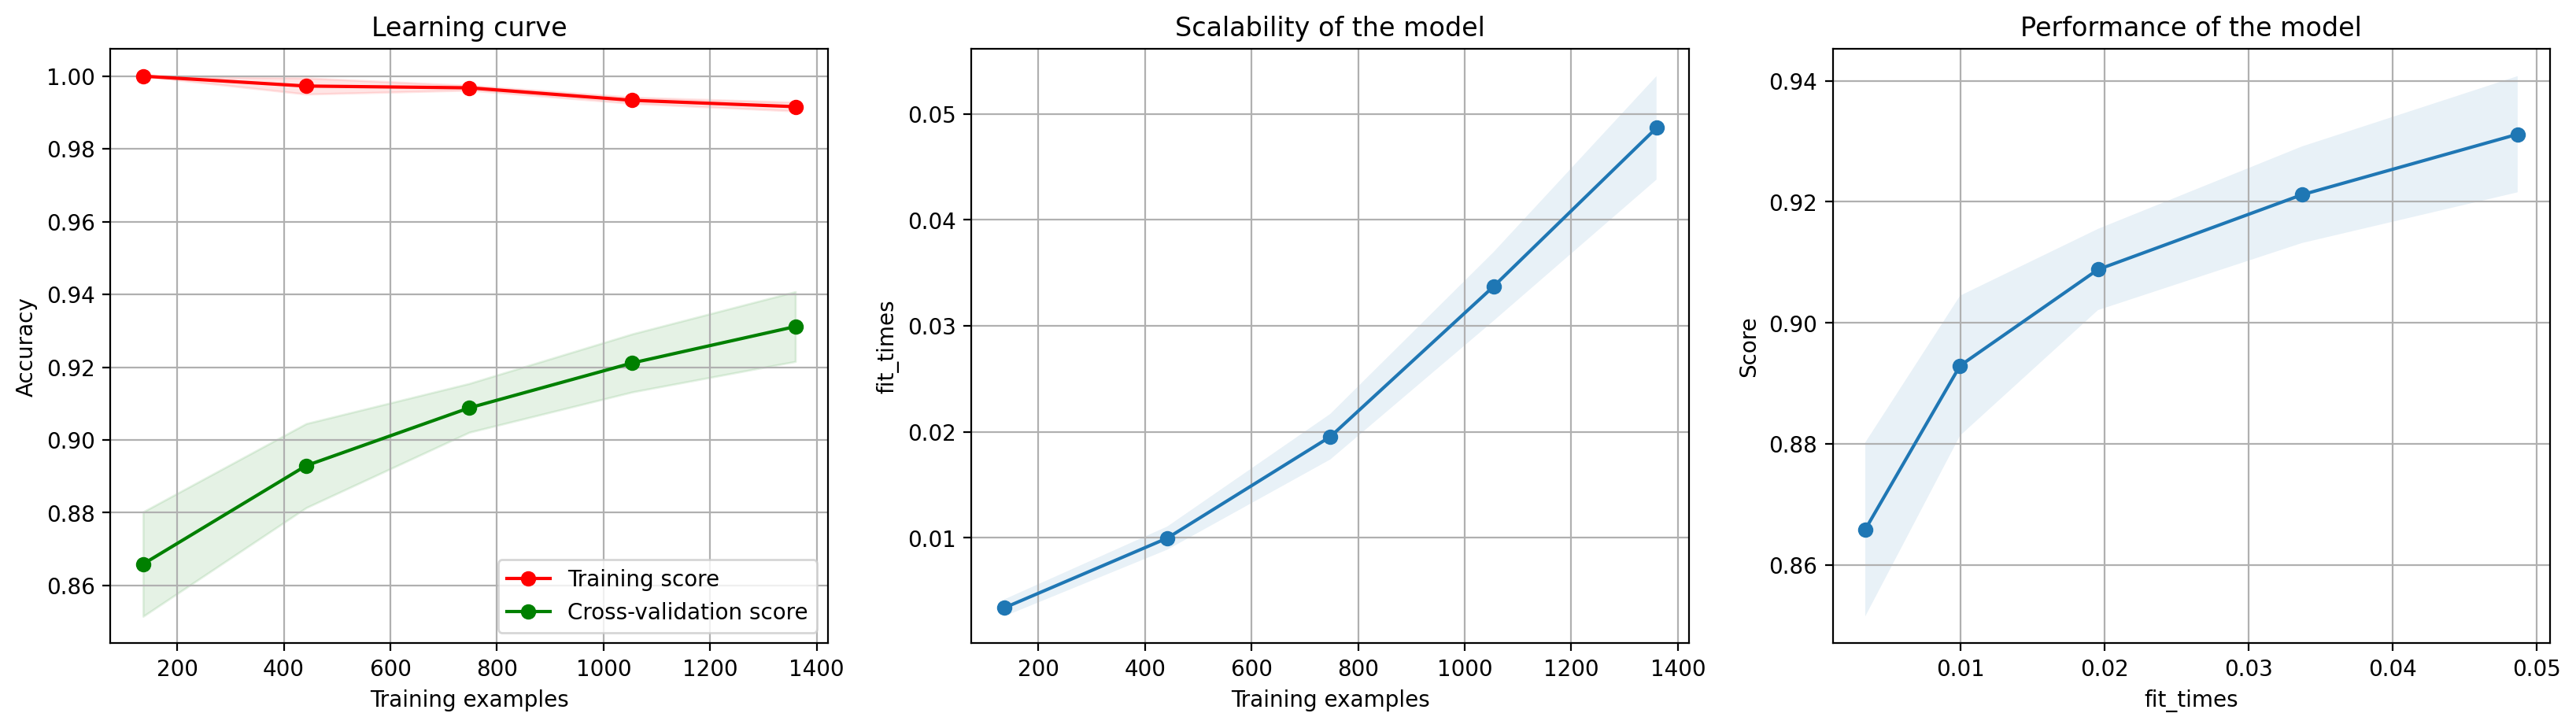

In [26]:
plot_learning_curve(best_estimators['svm'], X_train, y_train, 'accuracy', cv=5)

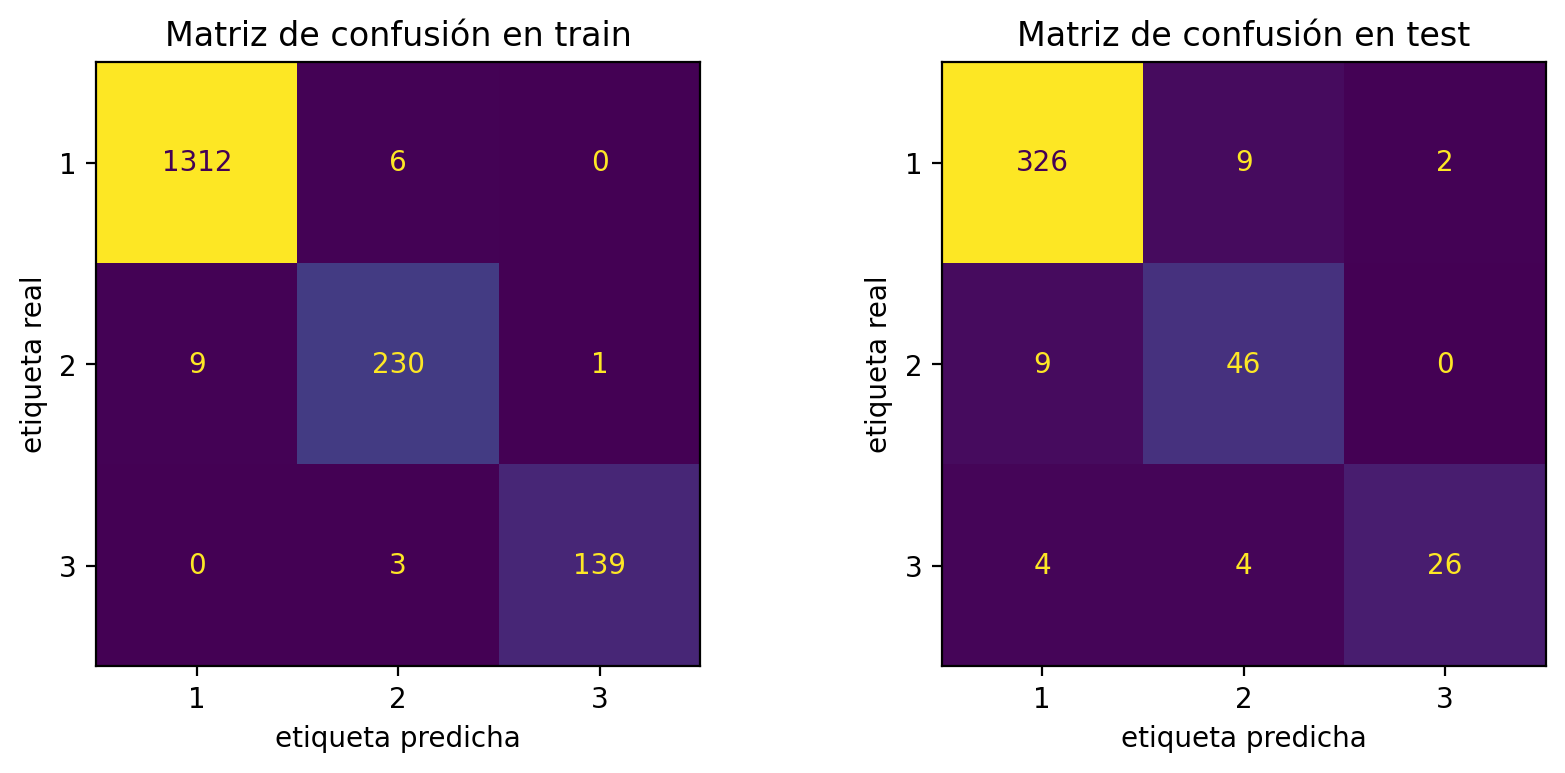

In [27]:
plot_confusion_matrix(best_estimators['svm'], X_train, X_test, y_train, y_test)

- se confunde más el 2 con el resto que 1 y 3
- el modelo está sesgado hacia los sanos (hay más ejemplos)
- sano a malo mal mal
- muy pocos datos, aunque buenos atributos : justificar que a través de la curva de aprendizaje con más datos tendríamos un modelo más fino

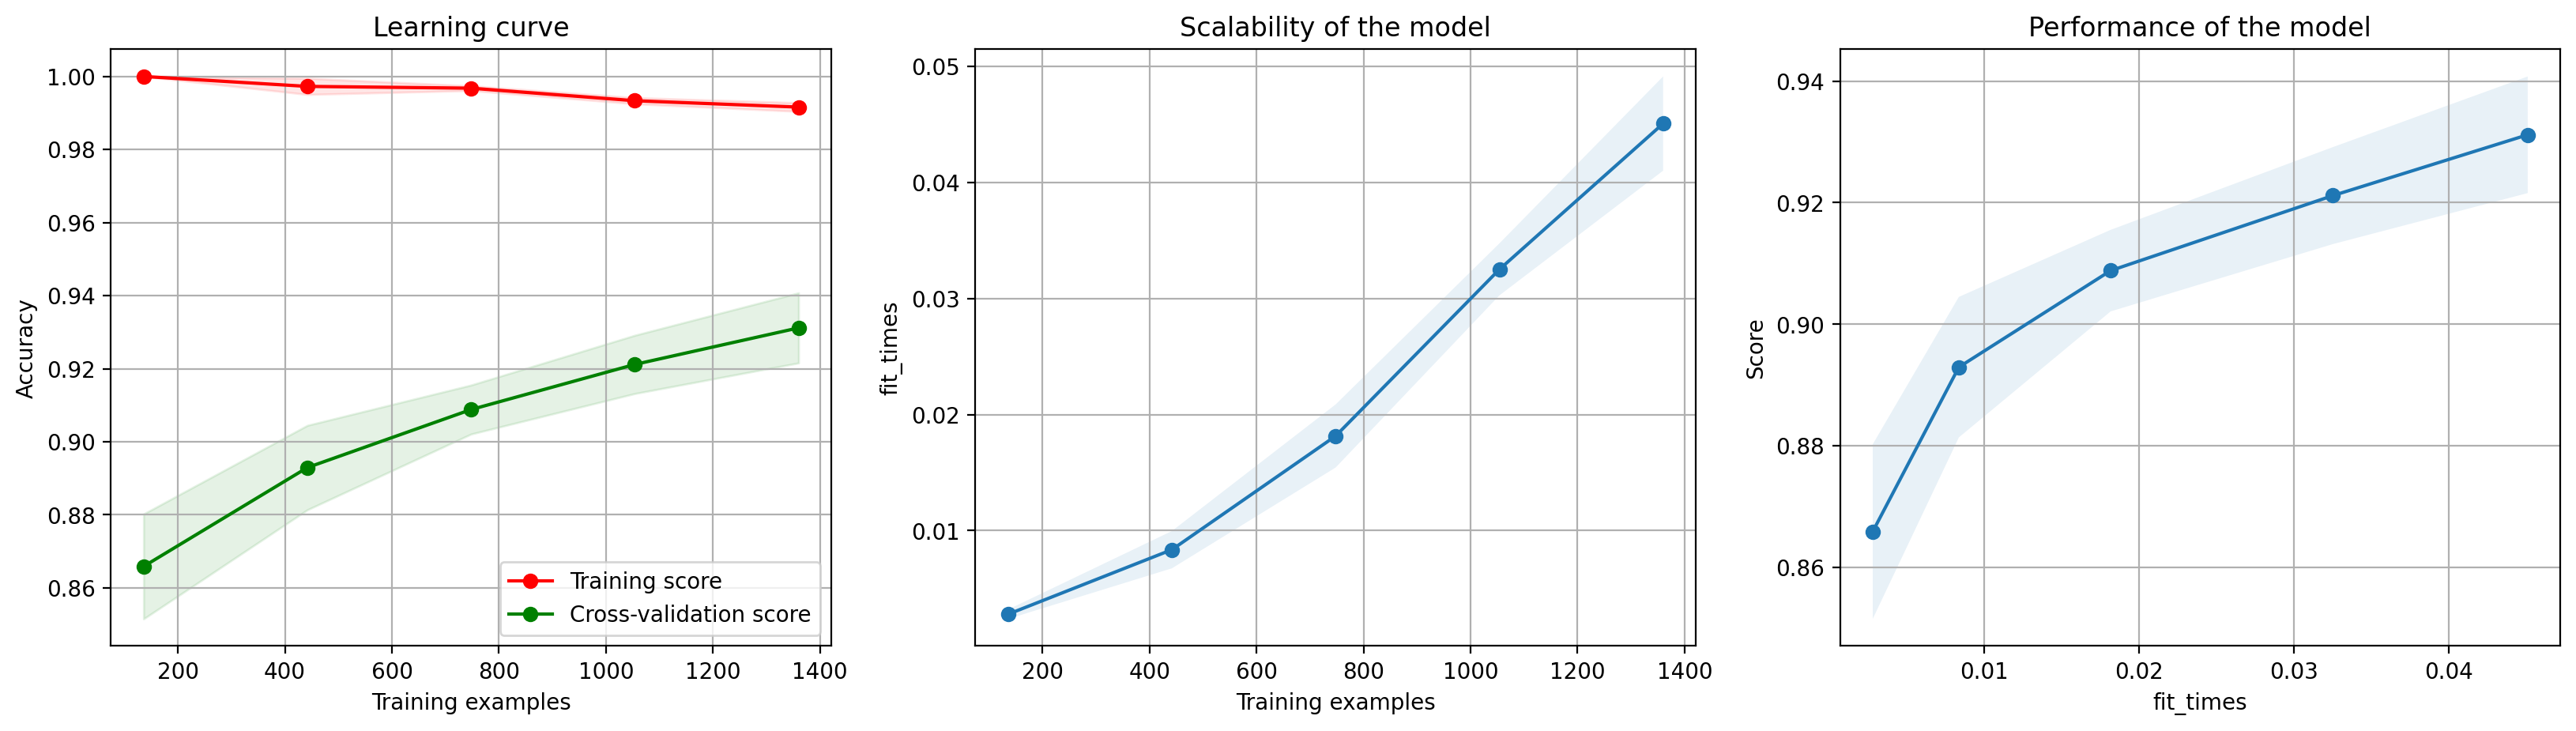

In [28]:
plot_learning_curve(best_estimators['svm'], X_train, y_train, 'accuracy', cv=5)